# Αυτό το notebook αφαιρεί πρατήρια που έχουν μείνει ως σήμεια στον χάρτη (έχουν κλείσει) και υπάρχουν καινούργια δίπλα τους 

##### 1. Βιβλιοθήκες

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.metrics.pairwise import haversine_distances
from pathlib import Path
import folium
from folium.plugins import MarkerCluster
import warnings
warnings.filterwarnings('ignore')

# Configuration
INPUT_FILE = "/Users/geo/Desktop/fuelstation-detection-thesis/data/ALL χιλιομετικές διευθύνσεις.xlsx"
OUTPUT_FILE = "/Users/geo/Desktop/fuelstation-detection-thesis/data/ALL_cleaned.xlsx"
DISTANCE_THRESHOLD = 10  # metra
ID_COLUMN = 'gasStationID'
SHEET_NAME = 0

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("Configuration loaded successfully")
print(f"Distance threshold: {DISTANCE_THRESHOLD}m")

Configuration loaded successfully
Distance threshold: 10m


#### 2. Data Loading

In [3]:
df_original = pd.read_excel(INPUT_FILE, sheet_name=SHEET_NAME)

print(f"\nDataset info:")
print(f"Total records: {len(df_original)}")
print(f"\nColumns: {list(df_original.columns)}")
df_original.head()

df = df_original.copy()

# Kraταme mono ta ROOFTOP pratiria
initial_len = len(df)
df = df[df['locationType'] == 'ROOFTOP'].copy()
print(f"Mono osa einai ROOFTOP: {len(df)} records (removed {initial_len - len(df)} non-ROOFTOP)")
print(f"Working with {len(df)} records")


Dataset info:
Total records: 1278

Columns: ['gasStationID', 'gasStationAddress', 'gasStationLat', 'gasStationLong', 'locationType', 'ddName', 'municipalityName', 'countyName']
Mono osa einai ROOFTOP: 1262 records (removed 16 non-ROOFTOP)
Working with 1262 records


#### 3. Στατιστικά

In [4]:
# Basic statistics
print("Geographic bounds:")
print(f"Latitude:  [{df['gasStationLat'].min():.6f}, {df['gasStationLat'].max():.6f}]")
print(f"Longitude: [{df['gasStationLong'].min():.6f}, {df['gasStationLong'].max():.6f}]")

# Katanomi ana locationType
if 'locationType' in df.columns:
    print("\nDistribution by location type:")
    print(df['locationType'].value_counts())

Geographic bounds:
Latitude:  [35.012526, 41.660139]
Longitude: [19.779975, 28.231500]

Distribution by location type:
locationType
ROOFTOP    1262
Name: count, dtype: int64


#### 4. Υπολογισμός αποστάσεων και cluster 

In [6]:
def remove_nearby_duplicates(df, distance_threshold=10, id_column='gasStationID'):

    print("\n \n \n")
    print(f"REMOVING DUPLICATE FUEL STATIONS")
    print("\n \n \n")
    print(f"Initial stations: {len(df)}")
    print(f"Distance threshold: {distance_threshold}m")
    
    df_work = df.copy()
    
    # Metatropi lat/lon se radians
    coords_rad = np.radians(df_work[['gasStationLat', 'gasStationLong']].values)
    
    # Ypologismos apostaseon
    print("\nCalculating distances...")
    distance_matrix_rad = haversine_distances(coords_rad)
    distance_matrix = distance_matrix_rad * 6371000  # metatropi se metra
    
    # DBSCAN clustering
    print("Finding clusters...")
    clustering = DBSCAN(eps=distance_threshold, min_samples=1, metric='precomputed')
    df_work['cluster'] = clustering.fit_predict(distance_matrix)
    
    # Statistika 
    n_clusters = df_work['cluster'].nunique()
    clusters_with_duplicates = df_work['cluster'].value_counts()
    clusters_with_duplicates = clusters_with_duplicates[clusters_with_duplicates > 1]
    
    print(f"\nTotal clusters: {n_clusters}")
    print(f"Clusters with duplicates: {len(clusters_with_duplicates)}")
    
    # Epilogi pratiriwn
    keep_indices = []
    remove_indices = []
    
    for cluster_id in df_work['cluster'].unique():
        cluster_members = df_work[df_work['cluster'] == cluster_id]
        
        if len(cluster_members) == 1:
            keep_indices.append(cluster_members.index[0])
        else:
            max_id_idx = cluster_members[id_column].idxmax()
            keep_indices.append(max_id_idx)
            
            for idx in cluster_members.index:
                if idx != max_id_idx:
                    remove_indices.append(idx)
    
    # Dimiourgia cleaned kai removed DataFrames
    cleaned_df = df.loc[keep_indices].copy().reset_index(drop=True)
    removed_df = df.loc[remove_indices].copy().reset_index(drop=True)
    
    # Prosthiki replaced_by_id sto removed_df
    if len(removed_df) > 0:
        removed_df['replaced_by_id'] = None
        for idx in remove_indices:
            cluster_id = df_work.loc[idx, 'cluster']
            cluster_members = df_work[df_work['cluster'] == cluster_id]
            kept_id = cluster_members[id_column].max()
            removed_df.loc[removed_df.index[remove_indices.index(idx)], 'replaced_by_id'] = kept_id
    
    # Prosthiki cluster info sta cleaned data
    cleaned_df['cluster'] = df_work.loc[keep_indices, 'cluster'].values
    
    # Statistics
    stats = {
        'original_count': len(df),
        'kept_count': len(cleaned_df),
        'removed_count': len(removed_df),
        'clusters_total': n_clusters,
        'clusters_with_duplicates': len(clusters_with_duplicates),
        'distance_threshold': distance_threshold,
        'retention_rate': len(cleaned_df) / len(df) * 100
    }
    
    print("\n")
    print(f"RESULTS")
    print("\n")
    print(f"Initial stations:  {stats['original_count']}")
    print(f"Kept stations:     {stats['kept_count']}")
    print(f"Removed stations:  {stats['removed_count']}")
    print(f"Retention rate:    {stats['retention_rate']:.1f}%")
    print("\n")
    
    return cleaned_df, removed_df, stats, df_work

# Ektelesi
cleaned_df, removed_df, stats, df_work = remove_nearby_duplicates(
    df, 
    distance_threshold=DISTANCE_THRESHOLD,
    id_column=ID_COLUMN
)


 
 

REMOVING DUPLICATE FUEL STATIONS

 
 

Initial stations: 1262
Distance threshold: 10m

Calculating distances...
Finding clusters...

Total clusters: 1069
Clusters with duplicates: 160


RESULTS


Initial stations:  1262
Kept stations:     1069
Removed stations:  193
Retention rate:    84.7%




### Αποτελέσματα

In [7]:
stats_df = pd.DataFrame([stats])
print("\n Overall Statistics:")
display(stats_df)

cluster_sizes = df_work['cluster'].value_counts().sort_index()
cluster_size_dist = cluster_sizes.value_counts().sort_index()

print("\nCluster Size Distribution:")
print("(How many stations were in each cluster)")
cluster_dist_df = pd.DataFrame({
    'Stations per Cluster': cluster_size_dist.index,
    'Number of Clusters': cluster_size_dist.values
})
display(cluster_dist_df)

# Statistics ana perioxι (municipalityName)
if 'municipalityName' in df.columns:
    print("\nStatistics by Municipality:")
    
    # Ypologismos gia kathe municipality
    muni_stats = []
    for muni in df['municipalityName'].unique():
        if pd.isna(muni):
            continue
        original = len(df[df['municipalityName'] == muni])
        kept = len(cleaned_df[cleaned_df['municipalityName'] == muni])
        removed = original - kept
        retention = (kept / original * 100) if original > 0 else 0
        
        muni_stats.append({
            'Municipality': muni,
            'Original': original,
            'Kept': kept,
            'Removed': removed,
            'Retention %': f"{retention:.1f}%"
        })
    
    muni_df = pd.DataFrame(muni_stats).sort_values('Removed', ascending=False)
    display(muni_df.head(10))  


 Overall Statistics:


,original_count,kept_count,removed_count,clusters_total,clusters_with_duplicates,distance_threshold,retention_rate
0,1262,1069,193,1069,160,10,84.706815



Cluster Size Distribution:
(How many stations were in each cluster)


,Stations per Cluster,Number of Clusters
0,1,909
1,2,130
2,3,27
3,4,3



Statistics by Municipality:


,Municipality,Original,Kept,Removed,Retention %
61,ΔΗΜΟΣ ΘΕΡΜΗΣ,29,21,8,72.4%
48,ΔΗΜΟΣ ΤΡΙΚΚΑΙΩΝ,19,12,7,63.2%
8,ΔΗΜΟΣ ΘΗΒΑΙΩΝ,20,14,6,70.0%
92,ΔΗΜΟΣ ΞΑΝΘΗΣ,19,13,6,68.4%
112,ΔΗΜΟΣ ΠΑΛΛΗΝΗΣ,11,7,4,63.6%
123,ΔΗΜΟΣ ΑΣΠΡΟΠΥΡΓΟΥ,13,9,4,69.2%
148,ΔΗΜΟΣ ΑΝΔΡΑΒΙΔΑΣ,9,5,4,55.6%
43,ΔΗΜΟΣ ΛΑΡΙΣΑΣ,27,23,4,85.2%
60,ΔΗΜΟΣ ΘΕΡΜΑΙΚΟΥ,9,5,4,55.6%
54,ΔΗΜΟΣ ΔΡΑΜΑΣ,12,8,4,66.7%


### Διαγράμματα 

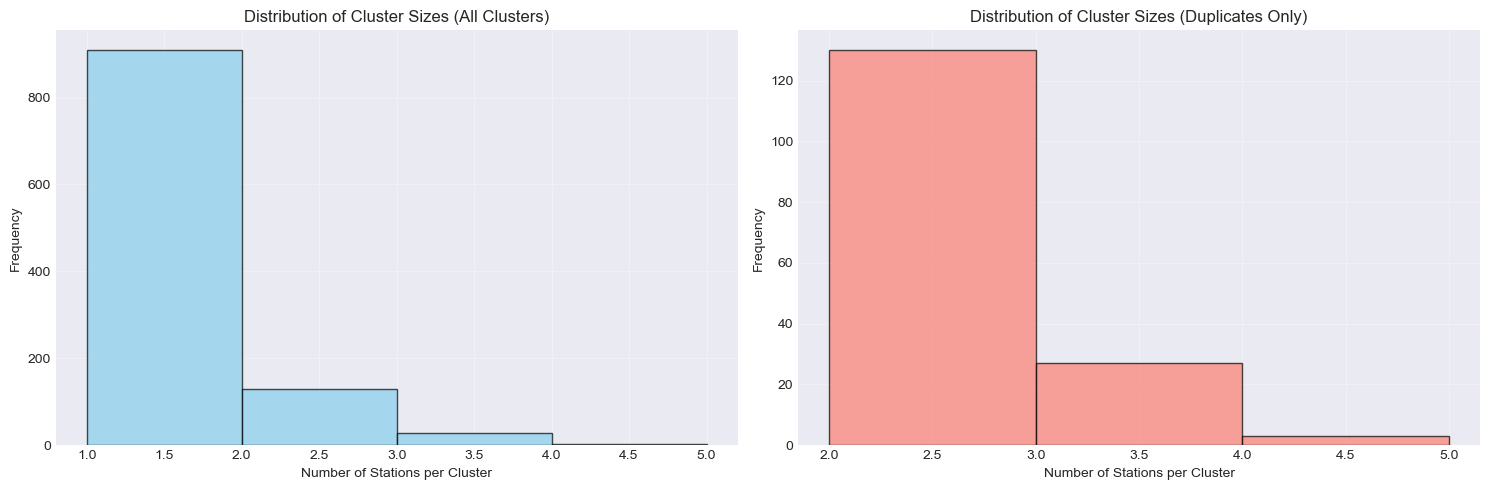


Max stations in a single cluster: 4
Average cluster size: 1.18


In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# All clusters
cluster_sizes = df_work['cluster'].value_counts()
ax1.hist(cluster_sizes.values, bins=range(1, cluster_sizes.max()+2), 
         edgecolor='black', alpha=0.7, color='skyblue')
ax1.set_xlabel('Number of Stations per Cluster')
ax1.set_ylabel('Frequency')
ax1.set_title('Distribution of Cluster Sizes (All Clusters)')
ax1.grid(True, alpha=0.3)

# Only clusters with duplicates
duplicates_only = cluster_sizes[cluster_sizes > 1]
ax2.hist(duplicates_only.values, bins=range(2, duplicates_only.max()+2),
         edgecolor='black', alpha=0.7, color='salmon')
ax2.set_xlabel('Number of Stations per Cluster')
ax2.set_ylabel('Frequency')
ax2.set_title('Distribution of Cluster Sizes (Duplicates Only)')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nMax stations in a single cluster: {cluster_sizes.max()}")
print(f"Average cluster size: {cluster_sizes.mean():.2f}")

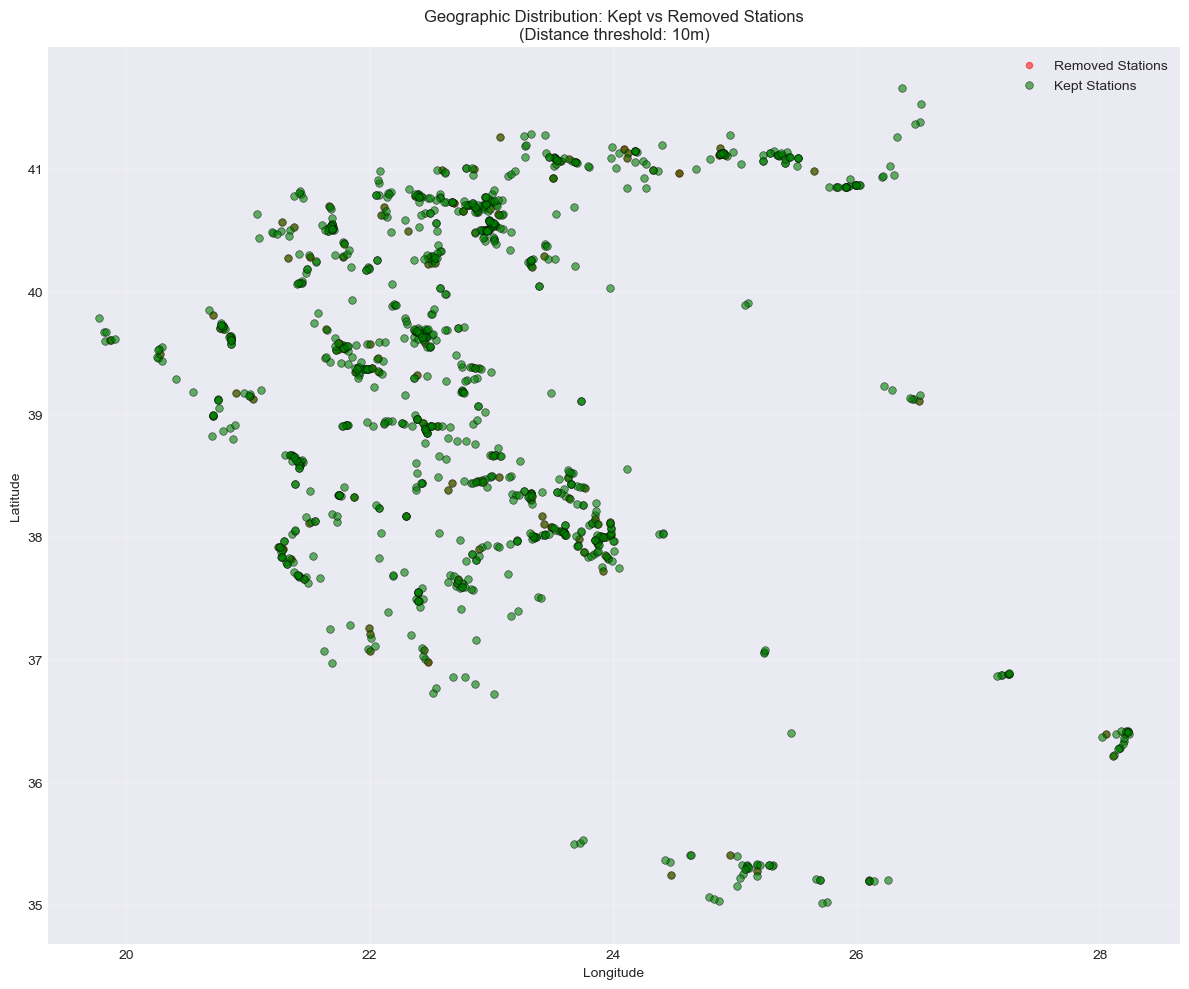

In [9]:
# Scatter plot: Cleaned vs Removed stations
fig, ax = plt.subplots(figsize=(12, 10))

# Plot removed stations (red)
if len(removed_df) > 0:
    ax.scatter(removed_df['gasStationLong'], removed_df['gasStationLat'], 
              c='red', alpha=0.5, s=20, label='Removed Stations')

# Plot kept stations (green)
ax.scatter(cleaned_df['gasStationLong'], cleaned_df['gasStationLat'],
          c='green', alpha=0.6, s=30, label='Kept Stations', edgecolors='black', linewidth=0.5)

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title(f'Geographic Distribution: Kept vs Removed Stations\n(Distance threshold: {DISTANCE_THRESHOLD}m)')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

#### Χάρτης με τα καινούργια βενζινάδικα

In [11]:
# Dimiourgia interactive map
print("Creating interactive map...")

# Ypologismos kentrou tou xarti
center_lat = df['gasStationLat'].mean()
center_lon = df['gasStationLong'].mean()

# Dimiourgia base map
m = folium.Map(
    location=[center_lat, center_lon],
    zoom_start=10,
    tiles='OpenStreetMap'
)

# Prosthiki kept stations (green markers)
kept_cluster = MarkerCluster(name='Kept Stations').add_to(m)
for idx, row in cleaned_df.iterrows():
    folium.CircleMarker(
        location=[row['gasStationLat'], row['gasStationLong']],
        radius=5,
        popup=f"ID: {row[ID_COLUMN]}<br>Address: {row.get('gasStationAddress', 'N/A')}",
        color='green',
        fill=True,
        fillColor='green',
        fillOpacity=0.7
    ).add_to(kept_cluster)

# Prosthiki removed stations (red markers)
if len(removed_df) > 0:
    removed_cluster = MarkerCluster(name='Removed Stations').add_to(m)
    for idx, row in removed_df.iterrows():
        folium.CircleMarker(
            location=[row['gasStationLat'], row['gasStationLong']],
            radius=4,
            popup=f"ID: {row[ID_COLUMN]}<br>Replaced by: {row['replaced_by_id']}<br>Address: {row.get('gasStationAddress', 'N/A')}",
            color='red',
            fill=True,
            fillColor='red',
            fillOpacity=0.6
        ).add_to(removed_cluster)

# Prosthiki layer control
folium.LayerControl().add_to(m)

# Apothikeusi map
map_path = Path(OUTPUT_FILE).parent / 'fuel_stations_map_cleaned.html'
m.save(str(map_path))
print(f"Map saved to: {map_path}")

m

Creating interactive map...
Map saved to: /Users/geo/Desktop/fuelstation-detection-thesis/data/fuel_stations_map_cleaned.html


In [13]:
# Apothikeusi Excel
print(f"\nSaving results to: {OUTPUT_FILE}")

with pd.ExcelWriter(OUTPUT_FILE, engine='openpyxl') as writer:
    # Cleaned data
    cleaned_df.to_excel(writer, sheet_name='Cleaned', index=False)
    
    # Removed data
    if len(removed_df) > 0:
        removed_df.to_excel(writer, sheet_name='Removed', index=False)
    
    # Statistics
    stats_summary = pd.DataFrame([stats])
    stats_summary.to_excel(writer, sheet_name='Statistics', index=False)
    
    # Cluster size distribution
    cluster_dist_df.to_excel(writer, sheet_name='Cluster_Distribution', index=False)
    
    # Municipality statistics
    if 'municipalityName' in df.columns:
        muni_df.to_excel(writer, sheet_name='Municipality_Stats', index=False)

print("Results saved successfully!")
print(f"\nOutput file contains:")
print(f"  - Sheet 'Cleaned': {len(cleaned_df)} stations")
print(f"  - Sheet 'Removed': {len(removed_df)} stations")
if 'municipalityName' in df.columns:
    print(f"  - Sheet 'Municipality_Stats': Statistics by municipality")


Saving results to: /Users/geo/Desktop/fuelstation-detection-thesis/data/ALL_cleaned.xlsx
Results saved successfully!

Output file contains:
  - Sheet 'Cleaned': 1069 stations
  - Sheet 'Removed': 193 stations
  - Sheet 'Municipality_Stats': Statistics by municipality


In [14]:
print("Top 10 Largest Clusters:")
print("="*60)

large_clusters = df_work['cluster'].value_counts().head(10)
for cluster_id, count in large_clusters.items():
    if count > 1:
        cluster_data = df_work[df_work['cluster'] == cluster_id]
        print(f"\nCluster {cluster_id}: {count} stations")
        print(f"IDs: {cluster_data[ID_COLUMN].tolist()}")
        if 'municipalityName' in cluster_data.columns:
            print(f"Municipality: {cluster_data['municipalityName'].iloc[0]}")

Top 10 Largest Clusters:

Cluster 790: 4 stations
IDs: [9936, 10994, 11291, 13510]
Municipality: ΔΗΜΟΣ ΘΕΣΣΑΛΟΝΙΚΗΣ

Cluster 882: 4 stations
IDs: [11286, 12249, 13146, 13891]
Municipality: ΔΗΜΟΣ ΕΧΕΔΩΡΟΥ

Cluster 729: 4 stations
IDs: [8617, 10648, 12321, 14583]
Municipality: ΔΗΜΟΣ ΑΓΙΟΥ ΑΘΑΝΑΣΙΟΥ

Cluster 391: 3 stations
IDs: [2532, 11737, 13242]
Municipality: ΔΗΜΟΣ ΑΜΑΛΙΑΔΟΣ

Cluster 554: 3 stations
IDs: [3918, 13438, 14667]
Municipality: ΔΗΜΟΣ ΝΙΓΡΙΤΗΣ

Cluster 654: 3 stations
IDs: [4768, 12169, 13796]
Municipality: ΔΗΜΟΣ ΣΙΑΤΙΣΤΑΣ

Cluster 258: 3 stations
IDs: [1542, 13196, 14109]
Municipality: ΔΗΜΟΣ ΑΝΔΡΑΒΙΔΑΣ

Cluster 506: 3 stations
IDs: [3530, 14516, 14701]
Municipality: ΔΗΜΟΣ ΘΕΡΜΗΣ

Cluster 941: 3 stations
IDs: [12337, 13811, 14795]
Municipality: ΔΗΜΟΣ ΘΗΒΑΙΩΝ

Cluster 913: 3 stations
IDs: [11754, 13302, 13816]
Municipality: ΔΗΜΟΣ ΠΑΛΛΗΝΗΣ


In [15]:
print(f"\n Saving results to: {OUTPUT_FILE}")

with pd.ExcelWriter(OUTPUT_FILE, engine='openpyxl') as writer:
    # Cleaned data
    cleaned_df.to_excel(writer, sheet_name='Cleaned', index=False)
    
    # Removed data
    if len(removed_df) > 0:
        removed_df.to_excel(writer, sheet_name='Removed', index=False)
    
    # Statistics
    stats_summary = pd.DataFrame([stats])
    stats_summary.to_excel(writer, sheet_name='Statistics', index=False)
    
    # Cluster size distribution
    cluster_dist_df.to_excel(writer, sheet_name='Cluster_Distribution', index=False)
    
    # Municipality statistics
    if 'municipalityName' in df.columns:
        muni_df.to_excel(writer, sheet_name='Municipality_Stats', index=False)

print("Results saved successfully!")
print(f"\nOutput file contains:")
print(f"  - Sheet 'Cleaned': {len(cleaned_df)} stations")
print(f"  - Sheet 'Removed': {len(removed_df)} stations")
print(f"  - Sheet 'Statistics': Overall statistics")
print(f"  - Sheet 'Cluster_Distribution': Cluster size analysis")
if 'municipalityName' in df.columns:
    print(f"  - Sheet 'Municipality_Stats': Statistics by municipality")


 Saving results to: /Users/geo/Desktop/fuelstation-detection-thesis/data/ALL_cleaned.xlsx
Results saved successfully!

Output file contains:
  - Sheet 'Cleaned': 1069 stations
  - Sheet 'Removed': 193 stations
  - Sheet 'Statistics': Overall statistics
  - Sheet 'Cluster_Distribution': Cluster size analysis
  - Sheet 'Municipality_Stats': Statistics by municipality
